In [1]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [4]:
class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [5]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers

In [6]:
files_all=[]
for file in os.listdir("/content/drive/MyDrive/RGB-img/img/"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/MyDrive/RGB-img/img/'

centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []

for file in files_all[:51]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[49:100]:
  right_files_path.append(folder_path + file)

In [7]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.20, fy=0.20, interpolation = cv2.INTER_CUBIC)
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.20,fy=0.20, interpolation = cv2.INTER_CUBIC)
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)

100%|██████████| 51/51 [01:55<00:00,  2.26s/it]


In [8]:
images_left_bgr_no_enhance = []
images_right_bgr_no_enhance = []


for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  left_img = cv2.resize(left_image_sat,None,fx=0.20, fy=0.20, interpolation = cv2.INTER_CUBIC)
  images_left_bgr_no_enhance.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  right_img = cv2.resize(right_image_sat,None,fx=0.20,fy=0.20, interpolation = cv2.INTER_CUBIC)
  images_right_bgr_no_enhance.append(right_img)

100%|██████████| 51/51 [00:20<00:00,  2.50it/s]


In [9]:
star  = cv2.xfeatures2d.StarDetector_create()
brief  = cv2.xfeatures2d.BriefDescriptorExtractor_create()

keypoints_all_left_star = []
descriptors_all_left_brief = []
points_all_left_star=[]

keypoints_all_right_star = []
descriptors_all_right_brief = []
points_all_right_star=[]

for imgs in tqdm(images_left_bgr):
  kpt = star.detect(imgs,None)
  kpt,descrip = brief.compute(imgs, kpt)
  keypoints_all_left_star.append(kpt)
  descriptors_all_left_brief.append(descrip)
  points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
  kpt = star.detect(imgs,None)
  kpt,descrip = brief.compute(imgs, kpt)
  keypoints_all_right_star.append(kpt)
  descriptors_all_right_brief.append(descrip)
  points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 51/51 [00:02<00:00, 18.63it/s]


In [10]:
num_kps_star=[]
for j in tqdm (keypoints_all_left_star + keypoints_all_right_star):
  num_kps_star.append(len(j))

100%|██████████| 102/102 [00:00<00:00, 43066.14it/s]


In [11]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh)
    inliers = inliers.flatten()
    return H, inliers

In [15]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.9,thresh=4,disp=False):
  FLANN_INDEX_KDTREE = 2
  index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
  search_params = dict(checks=50)
  flann = cv2.FlannBasedMatcher(index_params, search_params)
  #flann = cv2.BFMatcher()

  lff1 = np.float32(descripts[0])
  lff = np.float32(descripts[1])


  matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)

  print("\nNumber of matches",len(matches_lf1_lf))

  matches_4 = []
  ratio = ratio
  # loop over the raw matches
  for m in matches_lf1_lf:
    # ensure the distance is within a certain ratio of each
    # other (i.e. Lowe’s ratio test)
    if len(m) == 2 and m[0].distance < m[1].distance * ratio:
        #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])

  print("Number of matches After Lowe's Ratio",len(matches_4))
  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  
  Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  
  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  '''
  if len(inlier_matchset)<50:
    matches_4 = []
    ratio = 0.67
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
    '''
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [16]:
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [17]:
H_left_star = []
H_right_star = []

num_matches_star = []
num_good_matches_star = []

for j in tqdm(range(len(images_left))):
  if j==len(images_left)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_star[j:j+2][::-1],points_all_left_star[j:j+2][::-1],descriptors_all_left_brief[j:j+2][::-1])
  H_left_star.append(H_a)
  num_matches_star.append(matches)
  num_good_matches_star.append(gd_matches)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_star[j:j+2][::-1],points_all_right_star[j:j+2][::-1],descriptors_all_right_brief[j:j+2][::-1])
  H_right_star.append(H_a)

  4%|▍         | 2/51 [00:00<00:06,  7.82it/s]


Number of matches 1695
Number of matches After Lowe's Ratio 501
Number of Robust matches 114



Number of matches 2778
Number of matches After Lowe's Ratio 705
Number of Robust matches 111




  6%|▌         | 3/51 [00:00<00:06,  7.60it/s]


Number of matches 1913
Number of matches After Lowe's Ratio 541
Number of Robust matches 122



Number of matches 2481
Number of matches After Lowe's Ratio 801
Number of Robust matches 330




 12%|█▏        | 6/51 [00:00<00:05,  7.78it/s]


Number of matches 2545
Number of matches After Lowe's Ratio 575
Number of Robust matches 58



Number of matches 2494
Number of matches After Lowe's Ratio 644
Number of Robust matches 169




 16%|█▌        | 8/51 [00:00<00:05,  8.33it/s]


Number of matches 2678
Number of matches After Lowe's Ratio 822
Number of Robust matches 265



Number of matches 2463
Number of matches After Lowe's Ratio 829
Number of Robust matches 304




 20%|█▉        | 10/51 [00:01<00:04,  8.93it/s]


Number of matches 2560
Number of matches After Lowe's Ratio 816
Number of Robust matches 263



Number of matches 2482
Number of matches After Lowe's Ratio 836
Number of Robust matches 336




 25%|██▌       | 13/51 [00:01<00:03,  9.63it/s]


Number of matches 2501
Number of matches After Lowe's Ratio 1172
Number of Robust matches 685



Number of matches 2346
Number of matches After Lowe's Ratio 1020
Number of Robust matches 660



Number of matches 2314
Number of matches After Lowe's Ratio 898
Number of Robust matches 437




 27%|██▋       | 14/51 [00:01<00:04,  8.83it/s]


Number of matches 2222
Number of matches After Lowe's Ratio 683
Number of Robust matches 156



Number of matches 2220
Number of matches After Lowe's Ratio 903
Number of Robust matches 413




 33%|███▎      | 17/51 [00:01<00:03,  9.07it/s]


Number of matches 2529
Number of matches After Lowe's Ratio 733
Number of Robust matches 156



Number of matches 2438
Number of matches After Lowe's Ratio 892
Number of Robust matches 333




 37%|███▋      | 19/51 [00:02<00:04,  7.94it/s]


Number of matches 2591
Number of matches After Lowe's Ratio 636
Number of Robust matches 14



Number of matches 2264
Number of matches After Lowe's Ratio 528
Number of Robust matches 12




 41%|████      | 21/51 [00:02<00:03,  7.86it/s]


Number of matches 2641
Number of matches After Lowe's Ratio 844
Number of Robust matches 257



Number of matches 2453
Number of matches After Lowe's Ratio 581
Number of Robust matches 10




 43%|████▎     | 22/51 [00:02<00:03,  7.38it/s]


Number of matches 2868
Number of matches After Lowe's Ratio 621
Number of Robust matches 7



Number of matches 2758
Number of matches After Lowe's Ratio 719


 47%|████▋     | 24/51 [00:02<00:03,  6.83it/s]

Number of Robust matches 137



Number of matches 2933
Number of matches After Lowe's Ratio 761
Number of Robust matches 57




 51%|█████     | 26/51 [00:03<00:03,  7.29it/s]


Number of matches 2184
Number of matches After Lowe's Ratio 511
Number of Robust matches 7



Number of matches 2150
Number of matches After Lowe's Ratio 723
Number of Robust matches 191




 53%|█████▎    | 27/51 [00:03<00:03,  7.91it/s]


Number of matches 1936
Number of matches After Lowe's Ratio 695
Number of Robust matches 258



Number of matches 2155
Number of matches After Lowe's Ratio 673
Number of Robust matches 213




 59%|█████▉    | 30/51 [00:03<00:02,  7.97it/s]


Number of matches 2987
Number of matches After Lowe's Ratio 893
Number of Robust matches 246



Number of matches 3532
Number of matches After Lowe's Ratio 1144
Number of Robust matches 361




 63%|██████▎   | 32/51 [00:04<00:02,  6.42it/s]


Number of matches 3835
Number of matches After Lowe's Ratio 1380
Number of Robust matches 511



Number of matches 3347
Number of matches After Lowe's Ratio 1208
Number of Robust matches 478




 67%|██████▋   | 34/51 [00:04<00:02,  7.41it/s]


Number of matches 2880
Number of matches After Lowe's Ratio 1120
Number of Robust matches 511



Number of matches 2479
Number of matches After Lowe's Ratio 990
Number of Robust matches 418



Number of matches 2396
Number of matches After Lowe's Ratio 1017


 73%|███████▎  | 37/51 [00:04<00:01,  8.59it/s]

Number of Robust matches 512



Number of matches 2569
Number of matches After Lowe's Ratio 1033
Number of Robust matches 492



Number of matches 2578
Number of matches After Lowe's Ratio 1100
Number of Robust matches 533




 76%|███████▋  | 39/51 [00:04<00:01,  8.58it/s]


Number of matches 2751
Number of matches After Lowe's Ratio 1087
Number of Robust matches 488



Number of matches 2687
Number of matches After Lowe's Ratio 1075
Number of Robust matches 462




 80%|████████  | 41/51 [00:05<00:01,  8.68it/s]


Number of matches 2436
Number of matches After Lowe's Ratio 948
Number of Robust matches 424



Number of matches 2320
Number of matches After Lowe's Ratio 714
Number of Robust matches 186




 84%|████████▍ | 43/51 [00:05<00:00,  9.22it/s]


Number of matches 2201
Number of matches After Lowe's Ratio 960
Number of Robust matches 512



Number of matches 2275
Number of matches After Lowe's Ratio 952
Number of Robust matches 437



Number of matches 2064
Number of matches After Lowe's Ratio 749
Number of Robust matches 276




 88%|████████▊ | 45/51 [00:05<00:00,  9.49it/s]


Number of matches 2251
Number of matches After Lowe's Ratio 813
Number of Robust matches 323



Number of matches 2275
Number of matches After Lowe's Ratio 1023
Number of Robust matches 495



Number of matches 2451
Number of matches After Lowe's Ratio 701


 94%|█████████▍| 48/51 [00:05<00:00,  9.03it/s]

Number of Robust matches 207



Number of matches 2296
Number of matches After Lowe's Ratio 647
Number of Robust matches 165




  0%|          | 0/51 [00:00<?, ?it/s]


Number of matches 2229
Number of matches After Lowe's Ratio 734
Number of Robust matches 207



Number of matches 2227
Number of matches After Lowe's Ratio 501
Number of Robust matches 8




  4%|▍         | 2/51 [00:00<00:06,  7.22it/s]


Number of matches 2438
Number of matches After Lowe's Ratio 629
Number of Robust matches 108



Number of matches 2001
Number of matches After Lowe's Ratio 466
Number of Robust matches 54




  8%|▊         | 4/51 [00:00<00:06,  7.52it/s]


Number of matches 2183
Number of matches After Lowe's Ratio 587
Number of Robust matches 103



Number of matches 2046
Number of matches After Lowe's Ratio 521
Number of Robust matches 42




 12%|█▏        | 6/51 [00:00<00:06,  7.43it/s]


Number of matches 2256
Number of matches After Lowe's Ratio 719
Number of Robust matches 197



Number of matches 2635
Number of matches After Lowe's Ratio 636
Number of Robust matches 10




 16%|█▌        | 8/51 [00:01<00:05,  7.65it/s]


Number of matches 1829
Number of matches After Lowe's Ratio 426
Number of Robust matches 34



Number of matches 1780
Number of matches After Lowe's Ratio 453
Number of Robust matches 21




 18%|█▊        | 9/51 [00:01<00:05,  7.73it/s]


Number of matches 2172
Number of matches After Lowe's Ratio 600
Number of Robust matches 103



Number of matches 2317
Number of matches After Lowe's Ratio 821
Number of Robust matches 355




 22%|██▏       | 11/51 [00:01<00:04,  8.38it/s]


Number of matches 2215
Number of matches After Lowe's Ratio 901
Number of Robust matches 458



Number of matches 2150
Number of matches After Lowe's Ratio 673
Number of Robust matches 231



Number of matches 2760
Number of matches After Lowe's Ratio 713


 25%|██▌       | 13/51 [00:01<00:04,  8.39it/s]

Number of Robust matches 60



Number of matches 1957
Number of matches After Lowe's Ratio 726
Number of Robust matches 365



Number of matches 2805
Number of matches After Lowe's Ratio 816


 31%|███▏      | 16/51 [00:01<00:04,  8.71it/s]

Number of Robust matches 223



Number of matches 2794
Number of matches After Lowe's Ratio 1076
Number of Robust matches 565




 35%|███▌      | 18/51 [00:02<00:03,  9.10it/s]


Number of matches 2658
Number of matches After Lowe's Ratio 1088
Number of Robust matches 614



Number of matches 2544
Number of matches After Lowe's Ratio 1049
Number of Robust matches 569



Number of matches 2360
Number of matches After Lowe's Ratio 1091


 41%|████      | 21/51 [00:02<00:03,  9.44it/s]

Number of Robust matches 698



Number of matches 2505
Number of matches After Lowe's Ratio 793
Number of Robust matches 245



Number of matches 2673
Number of matches After Lowe's Ratio 979
Number of Robust matches 449




 45%|████▌     | 23/51 [00:02<00:03,  9.27it/s]


Number of matches 2629
Number of matches After Lowe's Ratio 883
Number of Robust matches 376



Number of matches 2815
Number of matches After Lowe's Ratio 930
Number of Robust matches 363




 49%|████▉     | 25/51 [00:02<00:03,  8.66it/s]


Number of matches 2716
Number of matches After Lowe's Ratio 861
Number of Robust matches 280



Number of matches 2558
Number of matches After Lowe's Ratio 887
Number of Robust matches 348




 53%|█████▎    | 27/51 [00:03<00:02,  9.11it/s]


Number of matches 2373
Number of matches After Lowe's Ratio 793
Number of Robust matches 291



Number of matches 2509
Number of matches After Lowe's Ratio 997
Number of Robust matches 327




 57%|█████▋    | 29/51 [00:03<00:02,  8.31it/s]


Number of matches 2302
Number of matches After Lowe's Ratio 917
Number of Robust matches 315



Number of matches 2392
Number of matches After Lowe's Ratio 752
Number of Robust matches 134




 61%|██████    | 31/51 [00:03<00:02,  7.63it/s]


Number of matches 2331
Number of matches After Lowe's Ratio 705
Number of Robust matches 177



Number of matches 3178
Number of matches After Lowe's Ratio 694
Number of Robust matches 9




 63%|██████▎   | 32/51 [00:03<00:02,  6.87it/s]


Number of matches 3204
Number of matches After Lowe's Ratio 909
Number of Robust matches 157



Number of matches 3448
Number of matches After Lowe's Ratio 792


 67%|██████▋   | 34/51 [00:04<00:02,  6.40it/s]

Number of Robust matches 8



Number of matches 3008
Number of matches After Lowe's Ratio 900
Number of Robust matches 115




 71%|███████   | 36/51 [00:04<00:02,  6.89it/s]


Number of matches 2615
Number of matches After Lowe's Ratio 806
Number of Robust matches 116



Number of matches 2506
Number of matches After Lowe's Ratio 913
Number of Robust matches 257




 75%|███████▍  | 38/51 [00:04<00:01,  6.92it/s]


Number of matches 2366
Number of matches After Lowe's Ratio 751
Number of Robust matches 141



Number of matches 2445
Number of matches After Lowe's Ratio 812
Number of Robust matches 159




 78%|███████▊  | 40/51 [00:05<00:01,  7.52it/s]


Number of matches 2493
Number of matches After Lowe's Ratio 789
Number of Robust matches 203



Number of matches 2586
Number of matches After Lowe's Ratio 1061
Number of Robust matches 442




 82%|████████▏ | 42/51 [00:05<00:01,  7.38it/s]


Number of matches 2619
Number of matches After Lowe's Ratio 872
Number of Robust matches 238



Number of matches 2477
Number of matches After Lowe's Ratio 576
Number of Robust matches 7




 86%|████████▋ | 44/51 [00:05<00:00,  8.14it/s]


Number of matches 2392
Number of matches After Lowe's Ratio 762
Number of Robust matches 247



Number of matches 2249
Number of matches After Lowe's Ratio 719
Number of Robust matches 195




 90%|█████████ | 46/51 [00:05<00:00,  8.32it/s]


Number of matches 2230
Number of matches After Lowe's Ratio 579
Number of Robust matches 110



Number of matches 2235
Number of matches After Lowe's Ratio 703
Number of Robust matches 228




 94%|█████████▍| 48/51 [00:05<00:00,  8.86it/s]


Number of matches 2067
Number of matches After Lowe's Ratio 642
Number of Robust matches 216



Number of matches 2039
Number of matches After Lowe's Ratio 927
Number of Robust matches 564



Number of matches 2408
Number of matches After Lowe's Ratio 780
Number of Robust matches 280




 98%|█████████▊| 50/51 [00:06<00:00,  8.18it/s]


Number of matches 2337
Number of matches After Lowe's Ratio 1013
Number of Robust matches 535




In [18]:
def warpnImages(images_left, images_right,H_left,H_right):
    #img1-centre,img2-left,img3-right

    h, w = images_left[0].shape[:2]

    pts_left = []
    pts_right = []

    pts_centre = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)

    for j in range(len(H_left)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_left.append(pts)

    for j in range(len(H_right)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_right.append(pts)

    pts_left_transformed=[]
    pts_right_transformed=[]



    for j,pts in enumerate(pts_left):
      if j==0:
        H_trans = H_left[j]
      else:
        H_trans = H_trans@H_left[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_left_transformed.append(pts_)

    for j,pts in enumerate(pts_right):
      if j==0:
        H_trans = H_right[j]
      else:
        H_trans = H_trans@H_right[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_right_transformed.append(pts_)


    print('Step1:Done')


    #pts = np.concatenate((pts1, pts2_), axis=0)

    pts_concat = np.concatenate((pts_centre,np.concatenate(np.array(pts_left_transformed),axis=0),np.concatenate(np.array(pts_right_transformed),axis=0)), axis=0)

    [xmin, ymin] = np.int32(pts_concat.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts_concat.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])  # translate

    print('Step2:Done')


    return xmax,xmin,ymax,ymin,t,h,w,Ht

In [19]:
def final_steps_left(images_left,images_right,H_left,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    warp_imgs_left = []


    for j,H in enumerate(H_left):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_left[j+1], H_trans, (xmax-xmin, ymax-ymin))

      if j==0:
        result[t[1]:h+t[1], t[0]:w+t[0]] = images_left[0]
      
      warp_imgs_left.append(result)

    print('Step31:Done')

    return warp_imgs_left

def final_steps_right(images_left,images_right,H_left,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    warp_imgs_right = []

    for j,H in enumerate(H_right):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_right[j+1], H_trans, (xmax-xmin, ymax-ymin))
      
      warp_imgs_right.append(result)

    print('Step32:Done')

    return warp_imgs_right

def final_steps_union(warp_imgs_left,warp_imgs_right):
    #Union

    warp_images_all = warp_imgs_left + warp_imgs_right

    warp_img_init = warp_images_all[0]



    #warp_final_all=[]

    for j,warp_img in enumerate(warp_images_all):
      if j==len(warp_images_all)-1:
        break
      black_pixels = np.where((warp_img_init[:, :, 0] == 0) & (warp_img_init[:, :, 1] == 0) & (warp_img_init[:, :, 2] == 0))

      warp_img_init[black_pixels] = warp_images_all[j+1][black_pixels]
    
      #warp_final = np.maximum(warp_img_init,warp_images_all[j+1])
      #warp_img_init = warp_final
      #warp_final_all.append(warp_final)

    print('Step4:Done')


    return warp_img_init

In [20]:
def final_steps_left_union(images_left,H_left,xmax,xmin,ymax,ymin,t,h,w,Ht):



    for j,H in enumerate(H_left):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      input_img = images_left[j+1]
      result = np.zeros((ymax-ymin,xmax-xmin,3),dtype='uint8')

      cv2.warpPerspective(src = np.uint8(input_img), M = H_trans, dsize = (xmax-xmin, ymax-ymin),dst=result)
      warp_img_init_curr = result

      if j==0:
        result[t[1]:h+t[1], t[0]:w+t[0]] = images_left[0]
        warp_img_init_prev = result
        continue

      black_pixels = np.where((warp_img_init_prev[:, :, 0] == 0) & (warp_img_init_prev[:, :, 1] == 0) & (warp_img_init_prev[:, :, 2] == 0))

      warp_img_init_prev[black_pixels] = warp_img_init_curr[black_pixels]

    print('Step31:Done')

    return warp_img_init_prev

def final_steps_right_union(warp_img_prev,images_right,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    for j,H in enumerate(H_right):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      input_img = images_right[j+1]
      result = np.zeros((ymax-ymin,xmax-xmin,3),dtype='uint8')

      cv2.warpPerspective(src = np.uint8(input_img), M = H_trans, dsize = (xmax-xmin, ymax-ymin),dst=result)
      warp_img_init_curr = result

      black_pixels = np.where((warp_img_prev[:, :, 0] == 0) & (warp_img_prev[:, :, 1] == 0) & (warp_img_prev[:, :, 2] == 0))

      warp_img_prev[black_pixels] = warp_img_init_curr[black_pixels]

    print('Step32:Done')

    return warp_img_prev

In [21]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_star,H_right_star)

Step1:Done
Step2:Done


In [22]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_star,xmax,xmin,ymax,ymin,t,h,w,Ht)

Step31:Done


In [23]:
warp_imgs_all_star = final_steps_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_star,xmax,xmin,ymax,ymin,t,h,w,Ht)

Step32:Done


Text(0.5, 1.0, '100-Images Mosaic-STARBRIEF')

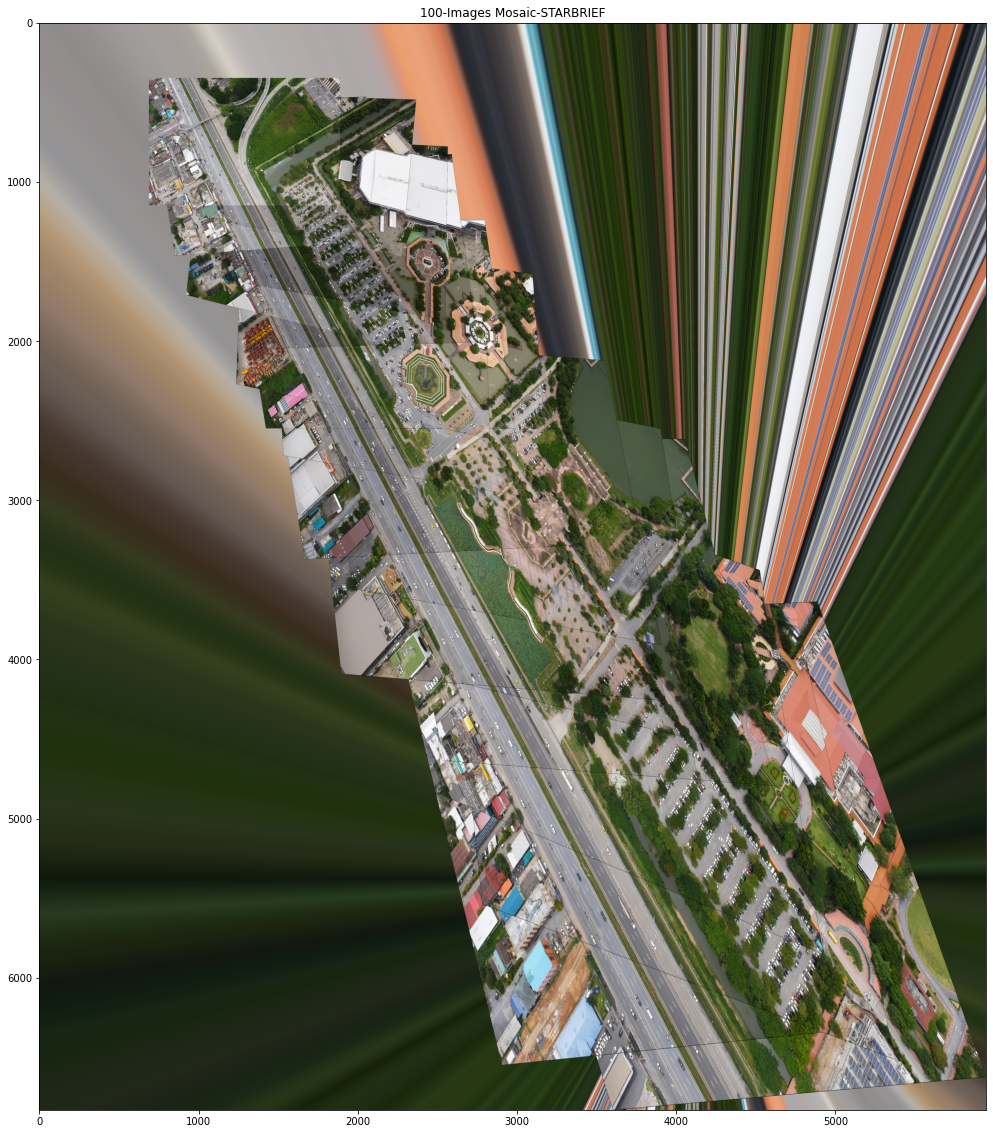

In [24]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_star , cv2.COLOR_BGR2RGB))
ax.set_title('100-Images Mosaic-STARBRIEF')